<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[05:10:26] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


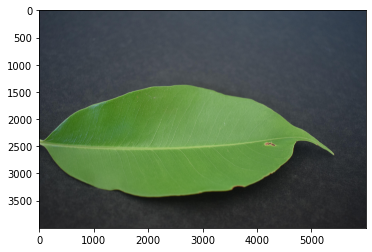

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

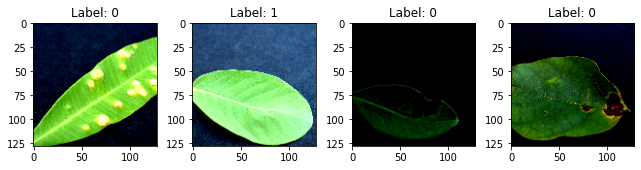

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[05:10:33] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[05:10:35] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2815046964476264 samples/sec                   batch loss = 1.3662889003753662 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.299761789587103 samples/sec                   batch loss = 0.6459636092185974 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2933523991852223 samples/sec                   batch loss = 0.9412533044815063 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.302576758221124 samples/sec                   batch loss = 0.4336366057395935 | accuracy = 0.5


Epoch[1] Batch[25] Speed: 1.3001091792477752 samples/sec                   batch loss = 0.4826974868774414 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2985825144636405 samples/sec                   batch loss = 1.0521352291107178 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.2875179211868373 samples/sec                   batch loss = 0.5779021382331848 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.3015651163627833 samples/sec                   batch loss = 0.5721121430397034 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.3038774953812695 samples/sec                   batch loss = 0.5156381726264954 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.3000471209677613 samples/sec                   batch loss = 0.45982763171195984 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.3061046547158242 samples/sec                   batch loss = 0.5538716316223145 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.3025907145274533 samples/sec                   batch loss = 0.47995612025260925 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.312295164289386 samples/sec                   batch loss = 0.2542588412761688 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.3047948044683961 samples/sec                   batch loss = 0.7495321035385132 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.3000680750491578 samples/sec                   batch loss = 0.7044805884361267 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.3002465143270951 samples/sec                   batch loss = 0.45443296432495117 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.3011384368810957 samples/sec                   batch loss = 0.5679333209991455 | accuracy = 0.6235294117647059


Epoch[1] Batch[90] Speed: 1.3002489328129407 samples/sec                   batch loss = 0.21138834953308105 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.302572207316329 samples/sec                   batch loss = 1.359950065612793 | accuracy = 0.6342105263157894


Epoch[1] Batch[100] Speed: 1.3015190735990756 samples/sec                   batch loss = 0.4589032232761383 | accuracy = 0.6375


Epoch[1] Batch[105] Speed: 1.2983534873347353 samples/sec                   batch loss = 0.2836931347846985 | accuracy = 0.6452380952380953


Epoch[1] Batch[110] Speed: 1.2965042362075578 samples/sec                   batch loss = 1.3246724605560303 | accuracy = 0.6363636363636364


Epoch[1] Batch[115] Speed: 1.2942149176000626 samples/sec                   batch loss = 0.4291554093360901 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.2907723238341962 samples/sec                   batch loss = 0.8891825079917908 | accuracy = 0.6479166666666667


Epoch[1] Batch[125] Speed: 1.2918003724821496 samples/sec                   batch loss = 0.35362857580184937 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2952138615512412 samples/sec                   batch loss = 0.4438791871070862 | accuracy = 0.6557692307692308


Epoch[1] Batch[135] Speed: 1.293723305781759 samples/sec                   batch loss = 0.9415766596794128 | accuracy = 0.6537037037037037


Epoch[1] Batch[140] Speed: 1.291953765946302 samples/sec                   batch loss = 0.8247894048690796 | accuracy = 0.6607142857142857


Epoch[1] Batch[145] Speed: 1.2874247531521241 samples/sec                   batch loss = 0.6698809266090393 | accuracy = 0.6586206896551724


Epoch[1] Batch[150] Speed: 1.2804474219659885 samples/sec                   batch loss = 0.5905823111534119 | accuracy = 0.655


Epoch[1] Batch[155] Speed: 1.2865722451205668 samples/sec                   batch loss = 0.353988379240036 | accuracy = 0.6580645161290323


Epoch[1] Batch[160] Speed: 1.2913882210007332 samples/sec                   batch loss = 0.2946062386035919 | accuracy = 0.6609375


Epoch[1] Batch[165] Speed: 1.2997335956163045 samples/sec                   batch loss = 0.25109824538230896 | accuracy = 0.6666666666666666


Epoch[1] Batch[170] Speed: 1.3072279651708525 samples/sec                   batch loss = 0.5048314332962036 | accuracy = 0.6617647058823529


Epoch[1] Batch[175] Speed: 1.2982121318013848 samples/sec                   batch loss = 0.609472930431366 | accuracy = 0.6614285714285715


Epoch[1] Batch[180] Speed: 1.291238241278732 samples/sec                   batch loss = 0.5226975679397583 | accuracy = 0.6611111111111111


Epoch[1] Batch[185] Speed: 1.2989622604331217 samples/sec                   batch loss = 0.627159595489502 | accuracy = 0.6648648648648648


Epoch[1] Batch[190] Speed: 1.3004461704612846 samples/sec                   batch loss = 0.47326159477233887 | accuracy = 0.6644736842105263


Epoch[1] Batch[195] Speed: 1.303689345948323 samples/sec                   batch loss = 0.41045284271240234 | accuracy = 0.6666666666666666


Epoch[1] Batch[200] Speed: 1.3026272248302382 samples/sec                   batch loss = 1.097436547279358 | accuracy = 0.6675


Epoch[1] Batch[205] Speed: 1.296356271236862 samples/sec                   batch loss = 0.9422537684440613 | accuracy = 0.6670731707317074


Epoch[1] Batch[210] Speed: 1.2939094875036807 samples/sec                   batch loss = 0.3081413507461548 | accuracy = 0.6702380952380952


Epoch[1] Batch[215] Speed: 1.2963004800816418 samples/sec                   batch loss = 0.5510121583938599 | accuracy = 0.6674418604651163


Epoch[1] Batch[220] Speed: 1.297534615429829 samples/sec                   batch loss = 0.8249412775039673 | accuracy = 0.6636363636363637


Epoch[1] Batch[225] Speed: 1.3002737228115933 samples/sec                   batch loss = 0.5676367878913879 | accuracy = 0.6655555555555556


Epoch[1] Batch[230] Speed: 1.2970119014790786 samples/sec                   batch loss = 0.49813392758369446 | accuracy = 0.6684782608695652


Epoch[1] Batch[235] Speed: 1.2945341762421894 samples/sec                   batch loss = 0.35927730798721313 | accuracy = 0.6702127659574468


Epoch[1] Batch[240] Speed: 1.2965132534451786 samples/sec                   batch loss = 0.5451090335845947 | accuracy = 0.6729166666666667


Epoch[1] Batch[245] Speed: 1.2983138001930306 samples/sec                   batch loss = 0.3951628804206848 | accuracy = 0.6724489795918367


Epoch[1] Batch[250] Speed: 1.3083349462784015 samples/sec                   batch loss = 0.5215556621551514 | accuracy = 0.676


Epoch[1] Batch[255] Speed: 1.2915786032900842 samples/sec                   batch loss = 1.2576981782913208 | accuracy = 0.6784313725490196


Epoch[1] Batch[260] Speed: 1.29665674459182 samples/sec                   batch loss = 0.5783719420433044 | accuracy = 0.675


Epoch[1] Batch[265] Speed: 1.2970394761255657 samples/sec                   batch loss = 0.35525229573249817 | accuracy = 0.6754716981132075


Epoch[1] Batch[270] Speed: 1.2841360757989506 samples/sec                   batch loss = 0.7768105864524841 | accuracy = 0.6787037037037037


Epoch[1] Batch[275] Speed: 1.2844668030816089 samples/sec                   batch loss = 0.46566319465637207 | accuracy = 0.6790909090909091


Epoch[1] Batch[280] Speed: 1.281988239817735 samples/sec                   batch loss = 0.44391119480133057 | accuracy = 0.6821428571428572


Epoch[1] Batch[285] Speed: 1.3014388094652798 samples/sec                   batch loss = 0.4984308183193207 | accuracy = 0.6842105263157895


Epoch[1] Batch[290] Speed: 1.298916904453841 samples/sec                   batch loss = 0.5816890001296997 | accuracy = 0.6853448275862069


Epoch[1] Batch[295] Speed: 1.301054183862483 samples/sec                   batch loss = 0.6116754412651062 | accuracy = 0.6830508474576271


Epoch[1] Batch[300] Speed: 1.2974184203668173 samples/sec                   batch loss = 0.34373271465301514 | accuracy = 0.6841666666666667


Epoch[1] Batch[305] Speed: 1.3054458965898166 samples/sec                   batch loss = 0.4485103487968445 | accuracy = 0.6836065573770492


Epoch[1] Batch[310] Speed: 1.304193733047721 samples/sec                   batch loss = 0.5753357410430908 | accuracy = 0.6862903225806452


Epoch[1] Batch[315] Speed: 1.2959756445922352 samples/sec                   batch loss = 0.672184407711029 | accuracy = 0.6865079365079365


Epoch[1] Batch[320] Speed: 1.3038373684910778 samples/sec                   batch loss = 0.3748064935207367 | accuracy = 0.68671875


Epoch[1] Batch[325] Speed: 1.2997315818080515 samples/sec                   batch loss = 0.25041845440864563 | accuracy = 0.6892307692307692


Epoch[1] Batch[330] Speed: 1.3060620521343802 samples/sec                   batch loss = 0.5719570517539978 | accuracy = 0.6878787878787879


Epoch[1] Batch[335] Speed: 1.3041523701733302 samples/sec                   batch loss = 0.26241299510002136 | accuracy = 0.6873134328358209


Epoch[1] Batch[340] Speed: 1.3003142353317576 samples/sec                   batch loss = 0.3324832320213318 | accuracy = 0.6904411764705882


Epoch[1] Batch[345] Speed: 1.3050437732820366 samples/sec                   batch loss = 0.23191052675247192 | accuracy = 0.691304347826087


Epoch[1] Batch[350] Speed: 1.303191726109087 samples/sec                   batch loss = 0.43366163969039917 | accuracy = 0.6921428571428572


Epoch[1] Batch[355] Speed: 1.3091780337471273 samples/sec                   batch loss = 0.9097093343734741 | accuracy = 0.6922535211267605


Epoch[1] Batch[360] Speed: 1.300761249924213 samples/sec                   batch loss = 0.721379280090332 | accuracy = 0.6909722222222222


Epoch[1] Batch[365] Speed: 1.2982987297621769 samples/sec                   batch loss = 0.46901628375053406 | accuracy = 0.6924657534246575


Epoch[1] Batch[370] Speed: 1.2996830509165216 samples/sec                   batch loss = 1.013364315032959 | accuracy = 0.6925675675675675


Epoch[1] Batch[375] Speed: 1.30273140675166 samples/sec                   batch loss = 0.348893404006958 | accuracy = 0.694


Epoch[1] Batch[380] Speed: 1.299190596945497 samples/sec                   batch loss = 0.666868269443512 | accuracy = 0.6927631578947369


Epoch[1] Batch[385] Speed: 1.2989603495851618 samples/sec                   batch loss = 0.35247576236724854 | accuracy = 0.6928571428571428


Epoch[1] Batch[390] Speed: 1.3017142728568099 samples/sec                   batch loss = 0.9538474678993225 | accuracy = 0.6935897435897436


Epoch[1] Batch[395] Speed: 1.302374829782104 samples/sec                   batch loss = 0.35917261242866516 | accuracy = 0.6930379746835443


Epoch[1] Batch[400] Speed: 1.304429085011963 samples/sec                   batch loss = 0.2448447048664093 | accuracy = 0.693125


Epoch[1] Batch[405] Speed: 1.2951301740756984 samples/sec                   batch loss = 0.5760201215744019 | accuracy = 0.6919753086419753


Epoch[1] Batch[410] Speed: 1.301314747661278 samples/sec                   batch loss = 0.971703290939331 | accuracy = 0.6871951219512196


Epoch[1] Batch[415] Speed: 1.297771986942464 samples/sec                   batch loss = 0.8005046844482422 | accuracy = 0.6837349397590361


Epoch[1] Batch[420] Speed: 1.296014888568256 samples/sec                   batch loss = 0.5430922508239746 | accuracy = 0.6857142857142857


Epoch[1] Batch[425] Speed: 1.3018297234541738 samples/sec                   batch loss = 0.6380710005760193 | accuracy = 0.6829411764705883


Epoch[1] Batch[430] Speed: 1.3103053088432715 samples/sec                   batch loss = 0.8989033699035645 | accuracy = 0.6843023255813954


Epoch[1] Batch[435] Speed: 1.3084698407706996 samples/sec                   batch loss = 0.6472346782684326 | accuracy = 0.6850574712643678


Epoch[1] Batch[440] Speed: 1.2959271935739771 samples/sec                   batch loss = 0.29387715458869934 | accuracy = 0.6863636363636364


Epoch[1] Batch[445] Speed: 1.3042833616104523 samples/sec                   batch loss = 0.4060215950012207 | accuracy = 0.6887640449438203


Epoch[1] Batch[450] Speed: 1.296724593293832 samples/sec                   batch loss = 0.35041630268096924 | accuracy = 0.6883333333333334


Epoch[1] Batch[455] Speed: 1.2918426465516437 samples/sec                   batch loss = 0.522676408290863 | accuracy = 0.689010989010989


Epoch[1] Batch[460] Speed: 1.2978140504025284 samples/sec                   batch loss = 0.9907961487770081 | accuracy = 0.6891304347826087


Epoch[1] Batch[465] Speed: 1.2943622942621535 samples/sec                   batch loss = 0.6148754358291626 | accuracy = 0.6897849462365592


Epoch[1] Batch[470] Speed: 1.2889533045665176 samples/sec                   batch loss = 0.6337440609931946 | accuracy = 0.6893617021276596


Epoch[1] Batch[475] Speed: 1.293740564749004 samples/sec                   batch loss = 0.2015431672334671 | accuracy = 0.6889473684210526


Epoch[1] Batch[480] Speed: 1.2966633587762662 samples/sec                   batch loss = 0.5839669108390808 | accuracy = 0.6901041666666666


Epoch[1] Batch[485] Speed: 1.295468189858816 samples/sec                   batch loss = 0.4094189703464508 | accuracy = 0.6891752577319588


Epoch[1] Batch[490] Speed: 1.3006735164667163 samples/sec                   batch loss = 0.4206026494503021 | accuracy = 0.6903061224489796


Epoch[1] Batch[495] Speed: 1.2917217997979407 samples/sec                   batch loss = 0.9548848867416382 | accuracy = 0.6898989898989899


Epoch[1] Batch[500] Speed: 1.2942533561091836 samples/sec                   batch loss = 0.35966432094573975 | accuracy = 0.6915


Epoch[1] Batch[505] Speed: 1.2886645069633227 samples/sec                   batch loss = 0.39280474185943604 | accuracy = 0.6925742574257425


Epoch[1] Batch[510] Speed: 1.2995727120045448 samples/sec                   batch loss = 0.295115202665329 | accuracy = 0.692156862745098


Epoch[1] Batch[515] Speed: 1.2919157623552437 samples/sec                   batch loss = 0.5060685276985168 | accuracy = 0.691747572815534


Epoch[1] Batch[520] Speed: 1.2929752281713147 samples/sec                   batch loss = 0.7414807081222534 | accuracy = 0.6918269230769231


Epoch[1] Batch[525] Speed: 1.2977027237019407 samples/sec                   batch loss = 1.024021863937378 | accuracy = 0.6919047619047619


Epoch[1] Batch[530] Speed: 1.3049944388522263 samples/sec                   batch loss = 0.3737376928329468 | accuracy = 0.6924528301886792


Epoch[1] Batch[535] Speed: 1.3071194984939143 samples/sec                   batch loss = 0.6138375401496887 | accuracy = 0.6939252336448598


Epoch[1] Batch[540] Speed: 1.2969705918390932 samples/sec                   batch loss = 0.7886351346969604 | accuracy = 0.6939814814814815


Epoch[1] Batch[545] Speed: 1.2886194713525307 samples/sec                   batch loss = 0.403329998254776 | accuracy = 0.6935779816513762


Epoch[1] Batch[550] Speed: 1.2986675534368848 samples/sec                   batch loss = 0.5753354430198669 | accuracy = 0.6940909090909091


Epoch[1] Batch[555] Speed: 1.2987056537052966 samples/sec                   batch loss = 0.9047651886940002 | accuracy = 0.6936936936936937


Epoch[1] Batch[560] Speed: 1.3005887187067553 samples/sec                   batch loss = 0.3044812083244324 | accuracy = 0.6950892857142857


Epoch[1] Batch[565] Speed: 1.3041457807420018 samples/sec                   batch loss = 0.5491784811019897 | accuracy = 0.6951327433628318


Epoch[1] Batch[570] Speed: 1.3018991248746288 samples/sec                   batch loss = 0.5973619222640991 | accuracy = 0.6956140350877194


Epoch[1] Batch[575] Speed: 1.30463418728993 samples/sec                   batch loss = 0.4412654936313629 | accuracy = 0.6960869565217391


Epoch[1] Batch[580] Speed: 1.3014544576704226 samples/sec                   batch loss = 0.4553462564945221 | accuracy = 0.6969827586206897


Epoch[1] Batch[585] Speed: 1.2960323088498624 samples/sec                   batch loss = 0.7215137481689453 | accuracy = 0.697008547008547


Epoch[1] Batch[590] Speed: 1.3067186844658096 samples/sec                   batch loss = 0.5216971635818481 | accuracy = 0.6970338983050848


Epoch[1] Batch[595] Speed: 1.303485148253308 samples/sec                   batch loss = 0.7061899900436401 | accuracy = 0.6957983193277311


Epoch[1] Batch[600] Speed: 1.298664035055195 samples/sec                   batch loss = 0.44975438714027405 | accuracy = 0.6966666666666667


Epoch[1] Batch[605] Speed: 1.30382450003672 samples/sec                   batch loss = 0.4506368935108185 | accuracy = 0.6962809917355371


Epoch[1] Batch[610] Speed: 1.300388615634505 samples/sec                   batch loss = 0.3619993329048157 | accuracy = 0.6983606557377049


Epoch[1] Batch[615] Speed: 1.301586725274166 samples/sec                   batch loss = 0.27056124806404114 | accuracy = 0.697560975609756


Epoch[1] Batch[620] Speed: 1.3029135122592044 samples/sec                   batch loss = 0.5246301889419556 | accuracy = 0.6971774193548387


Epoch[1] Batch[625] Speed: 1.3073800525220725 samples/sec                   batch loss = 0.7510722875595093 | accuracy = 0.6968


Epoch[1] Batch[630] Speed: 1.297615000876693 samples/sec                   batch loss = 0.3474757671356201 | accuracy = 0.6968253968253968


Epoch[1] Batch[635] Speed: 1.2998090172285812 samples/sec                   batch loss = 1.7378294467926025 | accuracy = 0.6964566929133859


Epoch[1] Batch[640] Speed: 1.3058577203942197 samples/sec                   batch loss = 0.8485224843025208 | accuracy = 0.69765625


Epoch[1] Batch[645] Speed: 1.303522518941507 samples/sec                   batch loss = 0.3607668876647949 | accuracy = 0.6972868217054263


Epoch[1] Batch[650] Speed: 1.3002390573857077 samples/sec                   batch loss = 0.9494796395301819 | accuracy = 0.6957692307692308


Epoch[1] Batch[655] Speed: 1.3099471311925963 samples/sec                   batch loss = 0.20487645268440247 | accuracy = 0.6969465648854962


Epoch[1] Batch[660] Speed: 1.304204378329606 samples/sec                   batch loss = 0.2653517723083496 | accuracy = 0.6977272727272728


Epoch[1] Batch[665] Speed: 1.3009423006135992 samples/sec                   batch loss = 0.368550568819046 | accuracy = 0.6973684210526315


Epoch[1] Batch[670] Speed: 1.2994789990492401 samples/sec                   batch loss = 0.34304559230804443 | accuracy = 0.698134328358209


Epoch[1] Batch[675] Speed: 1.3044387199264542 samples/sec                   batch loss = 0.4802135229110718 | accuracy = 0.6985185185185185


Epoch[1] Batch[680] Speed: 1.3006526436973194 samples/sec                   batch loss = 0.218099445104599 | accuracy = 0.7


Epoch[1] Batch[685] Speed: 1.3076967685332472 samples/sec                   batch loss = 0.2569490969181061 | accuracy = 0.7014598540145985


Epoch[1] Batch[690] Speed: 1.307695647324395 samples/sec                   batch loss = 1.1320263147354126 | accuracy = 0.7007246376811594


Epoch[1] Batch[695] Speed: 1.3073039534896587 samples/sec                   batch loss = 1.0622509717941284 | accuracy = 0.7010791366906475


Epoch[1] Batch[700] Speed: 1.3003313682515516 samples/sec                   batch loss = 0.44240760803222656 | accuracy = 0.7007142857142857


Epoch[1] Batch[705] Speed: 1.3012667040409873 samples/sec                   batch loss = 0.2847505509853363 | accuracy = 0.700709219858156


Epoch[1] Batch[710] Speed: 1.301679530578989 samples/sec                   batch loss = 0.5337332487106323 | accuracy = 0.7007042253521126


Epoch[1] Batch[715] Speed: 1.3055249287308666 samples/sec                   batch loss = 0.3970799744129181 | accuracy = 0.7006993006993008


Epoch[1] Batch[720] Speed: 1.3002422819985142 samples/sec                   batch loss = 0.553168773651123 | accuracy = 0.7006944444444444


Epoch[1] Batch[725] Speed: 1.3026945871589837 samples/sec                   batch loss = 1.759139060974121 | accuracy = 0.7006896551724138


Epoch[1] Batch[730] Speed: 1.294770351197981 samples/sec                   batch loss = 0.7075589895248413 | accuracy = 0.701027397260274


Epoch[1] Batch[735] Speed: 1.294354105789269 samples/sec                   batch loss = 0.31125083565711975 | accuracy = 0.7013605442176871


Epoch[1] Batch[740] Speed: 1.3007329117318676 samples/sec                   batch loss = 0.2884766757488251 | accuracy = 0.7016891891891892


Epoch[1] Batch[745] Speed: 1.289212015513377 samples/sec                   batch loss = 0.846312940120697 | accuracy = 0.7016778523489933


Epoch[1] Batch[750] Speed: 1.2998094200377255 samples/sec                   batch loss = 0.38677680492401123 | accuracy = 0.7016666666666667


Epoch[1] Batch[755] Speed: 1.2911940193174054 samples/sec                   batch loss = 0.16617174446582794 | accuracy = 0.702317880794702


Epoch[1] Batch[760] Speed: 1.2986325715179183 samples/sec                   batch loss = 0.6745884418487549 | accuracy = 0.7019736842105263


Epoch[1] Batch[765] Speed: 1.2909338170444775 samples/sec                   batch loss = 0.31979864835739136 | accuracy = 0.7016339869281045


Epoch[1] Batch[770] Speed: 1.303979242304313 samples/sec                   batch loss = 1.0166937112808228 | accuracy = 0.7016233766233766


Epoch[1] Batch[775] Speed: 1.2990262267982169 samples/sec                   batch loss = 1.025661587715149 | accuracy = 0.7012903225806452


Epoch[1] Batch[780] Speed: 1.2970382728437992 samples/sec                   batch loss = 1.3183233737945557 | accuracy = 0.6996794871794871


Epoch[1] Batch[785] Speed: 1.3001494800050248 samples/sec                   batch loss = 0.5311987996101379 | accuracy = 0.6993630573248407


[Epoch 1] training: accuracy=0.699238578680203
[Epoch 1] time cost: 633.447512626648
[Epoch 1] validation: validation accuracy=0.7055555555555556


Epoch[2] Batch[5] Speed: 1.2836649559005517 samples/sec                   batch loss = 0.4127802550792694 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2987201303827935 samples/sec                   batch loss = 0.4522158205509186 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.297676425683437 samples/sec                   batch loss = 0.41710442304611206 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.29138603416737 samples/sec                   batch loss = 1.1414324045181274 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2936809085398573 samples/sec                   batch loss = 0.28418341279029846 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.295253559392328 samples/sec                   batch loss = 0.3811969757080078 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2971902048207349 samples/sec                   batch loss = 0.32200050354003906 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2970742719890378 samples/sec                   batch loss = 0.40612635016441345 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2949987155927045 samples/sec                   batch loss = 0.16211241483688354 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.2898848329195098 samples/sec                   batch loss = 0.45540469884872437 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.292637217179056 samples/sec                   batch loss = 0.5603896379470825 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2954998003533642 samples/sec                   batch loss = 0.5761100649833679 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2933899887954414 samples/sec                   batch loss = 0.3846508860588074 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2947080022296134 samples/sec                   batch loss = 0.542864978313446 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2958367079853317 samples/sec                   batch loss = 0.35922443866729736 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.291667997941919 samples/sec                   batch loss = 0.43845486640930176 | accuracy = 0.75625


Epoch[2] Batch[85] Speed: 1.2935346843170672 samples/sec                   batch loss = 0.23469915986061096 | accuracy = 0.7558823529411764


Epoch[2] Batch[90] Speed: 1.292458072304768 samples/sec                   batch loss = 0.5685243606567383 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.3001458528345597 samples/sec                   batch loss = 0.7016242146492004 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.2957423321686965 samples/sec                   batch loss = 0.5312201380729675 | accuracy = 0.755


Epoch[2] Batch[105] Speed: 1.2967538596229653 samples/sec                   batch loss = 0.4569630026817322 | accuracy = 0.7571428571428571


Epoch[2] Batch[110] Speed: 1.3029178631800866 samples/sec                   batch loss = 0.2761331796646118 | accuracy = 0.759090909090909


Epoch[2] Batch[115] Speed: 1.2921495895165402 samples/sec                   batch loss = 0.6163800954818726 | accuracy = 0.7608695652173914


Epoch[2] Batch[120] Speed: 1.2985530650279788 samples/sec                   batch loss = 0.6165828704833984 | accuracy = 0.7604166666666666


Epoch[2] Batch[125] Speed: 1.299377148094017 samples/sec                   batch loss = 0.5912399291992188 | accuracy = 0.76


Epoch[2] Batch[130] Speed: 1.2978692691071791 samples/sec                   batch loss = 1.1136353015899658 | accuracy = 0.7576923076923077


Epoch[2] Batch[135] Speed: 1.295142471557333 samples/sec                   batch loss = 0.4570055603981018 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.2888625030267944 samples/sec                   batch loss = 0.29082608222961426 | accuracy = 0.7571428571428571


Epoch[2] Batch[145] Speed: 1.2954694902601283 samples/sec                   batch loss = 0.6020536422729492 | accuracy = 0.753448275862069


Epoch[2] Batch[150] Speed: 1.2901565178018852 samples/sec                   batch loss = 0.039983123540878296 | accuracy = 0.7566666666666667


Epoch[2] Batch[155] Speed: 1.2902021570099749 samples/sec                   batch loss = 0.6093228459358215 | accuracy = 0.7532258064516129


Epoch[2] Batch[160] Speed: 1.2907087705520626 samples/sec                   batch loss = 0.3400231599807739 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.2927172957599233 samples/sec                   batch loss = 0.08356496691703796 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.2906318198766742 samples/sec                   batch loss = 0.21356269717216492 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.2856679563284672 samples/sec                   batch loss = 0.37719395756721497 | accuracy = 0.7628571428571429


Epoch[2] Batch[180] Speed: 1.2913669493905668 samples/sec                   batch loss = 0.18038824200630188 | accuracy = 0.7625


Epoch[2] Batch[185] Speed: 1.2992365757220516 samples/sec                   batch loss = 0.32818830013275146 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.2950897839905744 samples/sec                   batch loss = 0.37999051809310913 | accuracy = 0.7578947368421053


Epoch[2] Batch[195] Speed: 1.2937978319043801 samples/sec                   batch loss = 0.3902166485786438 | accuracy = 0.7576923076923077


Epoch[2] Batch[200] Speed: 1.2998449689279303 samples/sec                   batch loss = 0.5654733777046204 | accuracy = 0.755


Epoch[2] Batch[205] Speed: 1.2950233057967853 samples/sec                   batch loss = 0.44974276423454285 | accuracy = 0.7573170731707317


Epoch[2] Batch[210] Speed: 1.2951564689750834 samples/sec                   batch loss = 0.2438368797302246 | accuracy = 0.7583333333333333


Epoch[2] Batch[215] Speed: 1.298879093464207 samples/sec                   batch loss = 0.4473239481449127 | accuracy = 0.7604651162790698


Epoch[2] Batch[220] Speed: 1.2906804714950384 samples/sec                   batch loss = 0.6394301652908325 | accuracy = 0.7613636363636364


Epoch[2] Batch[225] Speed: 1.286627596698478 samples/sec                   batch loss = 0.5963806509971619 | accuracy = 0.7622222222222222


Epoch[2] Batch[230] Speed: 1.2953773682875598 samples/sec                   batch loss = 0.999504804611206 | accuracy = 0.7608695652173914


Epoch[2] Batch[235] Speed: 1.2985402001647206 samples/sec                   batch loss = 0.21484896540641785 | accuracy = 0.7648936170212766


Epoch[2] Batch[240] Speed: 1.2946110934789465 samples/sec                   batch loss = 0.55746990442276 | accuracy = 0.7625


Epoch[2] Batch[245] Speed: 1.2941032092837308 samples/sec                   batch loss = 0.6139720678329468 | accuracy = 0.7642857142857142


Epoch[2] Batch[250] Speed: 1.3011630589851182 samples/sec                   batch loss = 0.7989990711212158 | accuracy = 0.76


Epoch[2] Batch[255] Speed: 1.2908378697117646 samples/sec                   batch loss = 0.22970730066299438 | accuracy = 0.7588235294117647


Epoch[2] Batch[260] Speed: 1.296339944064235 samples/sec                   batch loss = 0.7766728401184082 | accuracy = 0.7567307692307692


Epoch[2] Batch[265] Speed: 1.2973958460204207 samples/sec                   batch loss = 0.25951147079467773 | accuracy = 0.7556603773584906


Epoch[2] Batch[270] Speed: 1.2965667583018 samples/sec                   batch loss = 0.31999558210372925 | accuracy = 0.7564814814814815


Epoch[2] Batch[275] Speed: 1.297487753604084 samples/sec                   batch loss = 0.5841996073722839 | accuracy = 0.7563636363636363


Epoch[2] Batch[280] Speed: 1.2930014356393065 samples/sec                   batch loss = 0.7244535088539124 | accuracy = 0.7526785714285714


Epoch[2] Batch[285] Speed: 1.2975714449788298 samples/sec                   batch loss = 0.41614142060279846 | accuracy = 0.7526315789473684


Epoch[2] Batch[290] Speed: 1.294936744424133 samples/sec                   batch loss = 1.368135690689087 | accuracy = 0.75


Epoch[2] Batch[295] Speed: 1.2972036447419624 samples/sec                   batch loss = 0.41482606530189514 | accuracy = 0.75


Epoch[2] Batch[300] Speed: 1.2988044835543913 samples/sec                   batch loss = 0.895726203918457 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.293800825100693 samples/sec                   batch loss = 0.38352108001708984 | accuracy = 0.7516393442622951


Epoch[2] Batch[310] Speed: 1.30054516458386 samples/sec                   batch loss = 0.25878003239631653 | accuracy = 0.7491935483870967


Epoch[2] Batch[315] Speed: 1.297022630384001 samples/sec                   batch loss = 0.2103675752878189 | accuracy = 0.7484126984126984


Epoch[2] Batch[320] Speed: 1.3018903356392566 samples/sec                   batch loss = 0.7048600912094116 | accuracy = 0.74765625


Epoch[2] Batch[325] Speed: 1.2970562220285506 samples/sec                   batch loss = 0.3417118787765503 | accuracy = 0.7484615384615385


Epoch[2] Batch[330] Speed: 1.29680157058063 samples/sec                   batch loss = 0.6870638132095337 | accuracy = 0.7477272727272727


Epoch[2] Batch[335] Speed: 1.2933361475899792 samples/sec                   batch loss = 0.48892566561698914 | accuracy = 0.7492537313432835


Epoch[2] Batch[340] Speed: 1.2872184087739336 samples/sec                   batch loss = 0.8220178484916687 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.2939469099114655 samples/sec                   batch loss = 0.4409414231777191 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2906722302485918 samples/sec                   batch loss = 0.36091896891593933 | accuracy = 0.75


Epoch[2] Batch[355] Speed: 1.2939403234107325 samples/sec                   batch loss = 0.3362917900085449 | accuracy = 0.75


Epoch[2] Batch[360] Speed: 1.2821417613116393 samples/sec                   batch loss = 0.2778569459915161 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.2836195815838118 samples/sec                   batch loss = 0.6986043453216553 | accuracy = 0.7506849315068493


Epoch[2] Batch[370] Speed: 1.277487461146477 samples/sec                   batch loss = 0.2730953097343445 | accuracy = 0.7520270270270271


Epoch[2] Batch[375] Speed: 1.2861234911030408 samples/sec                   batch loss = 0.4548649191856384 | accuracy = 0.7526666666666667


Epoch[2] Batch[380] Speed: 1.288955582196001 samples/sec                   batch loss = 0.6734159588813782 | accuracy = 0.75


Epoch[2] Batch[385] Speed: 1.2909250759102187 samples/sec                   batch loss = 0.7197434902191162 | accuracy = 0.7487012987012988


Epoch[2] Batch[390] Speed: 1.2880416123367877 samples/sec                   batch loss = 0.9219643473625183 | accuracy = 0.7480769230769231


Epoch[2] Batch[395] Speed: 1.2859865602069203 samples/sec                   batch loss = 0.5313495993614197 | accuracy = 0.7474683544303797


Epoch[2] Batch[400] Speed: 1.292424121036576 samples/sec                   batch loss = 0.46210259199142456 | accuracy = 0.74875


Epoch[2] Batch[405] Speed: 1.2901810236709066 samples/sec                   batch loss = 0.30858561396598816 | accuracy = 0.7475308641975309


Epoch[2] Batch[410] Speed: 1.2950825860220727 samples/sec                   batch loss = 0.7202142477035522 | accuracy = 0.7475609756097561


Epoch[2] Batch[415] Speed: 1.2879418429237846 samples/sec                   batch loss = 0.3063216209411621 | accuracy = 0.7487951807228915


Epoch[2] Batch[420] Speed: 1.2887100406710024 samples/sec                   batch loss = 0.36666154861450195 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.285178089516247 samples/sec                   batch loss = 0.2351418286561966 | accuracy = 0.7523529411764706


Epoch[2] Batch[430] Speed: 1.2847334555079184 samples/sec                   batch loss = 0.46126484870910645 | accuracy = 0.752906976744186


Epoch[2] Batch[435] Speed: 1.2904578955169452 samples/sec                   batch loss = 0.3042793273925781 | accuracy = 0.7540229885057471


Epoch[2] Batch[440] Speed: 1.2835352253089047 samples/sec                   batch loss = 0.2825864255428314 | accuracy = 0.7551136363636364


Epoch[2] Batch[445] Speed: 1.2903552703723646 samples/sec                   batch loss = 0.49969279766082764 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.2965800851046991 samples/sec                   batch loss = 1.061760425567627 | accuracy = 0.7533333333333333


Epoch[2] Batch[455] Speed: 1.2940368323324094 samples/sec                   batch loss = 0.49409985542297363 | accuracy = 0.7527472527472527


Epoch[2] Batch[460] Speed: 1.2946130914510414 samples/sec                   batch loss = 0.3328567147254944 | accuracy = 0.753804347826087


Epoch[2] Batch[465] Speed: 1.2939862307199343 samples/sec                   batch loss = 0.7262840270996094 | accuracy = 0.7532258064516129


Epoch[2] Batch[470] Speed: 1.2853836817444158 samples/sec                   batch loss = 0.8553568720817566 | accuracy = 0.7537234042553191


Epoch[2] Batch[475] Speed: 1.2970528126479768 samples/sec                   batch loss = 0.37958773970603943 | accuracy = 0.7547368421052632


Epoch[2] Batch[480] Speed: 1.3001234857305592 samples/sec                   batch loss = 0.17851097881793976 | accuracy = 0.7541666666666667


Epoch[2] Batch[485] Speed: 1.2707492764502675 samples/sec                   batch loss = 0.3003832697868347 | accuracy = 0.7546391752577319


Epoch[2] Batch[490] Speed: 1.2805841531869435 samples/sec                   batch loss = 0.27444201707839966 | accuracy = 0.7535714285714286


Epoch[2] Batch[495] Speed: 1.2750866089357362 samples/sec                   batch loss = 0.41157788038253784 | accuracy = 0.7540404040404041


Epoch[2] Batch[500] Speed: 1.2911621217606308 samples/sec                   batch loss = 0.22702522575855255 | accuracy = 0.7545


Epoch[2] Batch[505] Speed: 1.3008410270533768 samples/sec                   batch loss = 0.559904158115387 | accuracy = 0.7534653465346535


Epoch[2] Batch[510] Speed: 1.300735231181642 samples/sec                   batch loss = 0.7412286400794983 | accuracy = 0.7529411764705882


Epoch[2] Batch[515] Speed: 1.2954935981726647 samples/sec                   batch loss = 0.7447825074195862 | accuracy = 0.7529126213592233


Epoch[2] Batch[520] Speed: 1.2940931275337542 samples/sec                   batch loss = 0.2500661313533783 | accuracy = 0.7533653846153846


Epoch[2] Batch[525] Speed: 1.2998765919544897 samples/sec                   batch loss = 0.3393458425998688 | accuracy = 0.7552380952380953


Epoch[2] Batch[530] Speed: 1.300351021274343 samples/sec                   batch loss = 0.5212739706039429 | accuracy = 0.7556603773584906


Epoch[2] Batch[535] Speed: 1.294863486161069 samples/sec                   batch loss = 0.8520674705505371 | accuracy = 0.755607476635514


Epoch[2] Batch[540] Speed: 1.2942308917681433 samples/sec                   batch loss = 0.3069765865802765 | accuracy = 0.7564814814814815


Epoch[2] Batch[545] Speed: 1.2948120204425935 samples/sec                   batch loss = 0.7051769495010376 | accuracy = 0.7555045871559632


Epoch[2] Batch[550] Speed: 1.3044652927439946 samples/sec                   batch loss = 0.5499445796012878 | accuracy = 0.7563636363636363


Epoch[2] Batch[555] Speed: 1.2947490679423888 samples/sec                   batch loss = 0.5531954169273376 | accuracy = 0.7563063063063064


Epoch[2] Batch[560] Speed: 1.2946445603250143 samples/sec                   batch loss = 0.22428350150585175 | accuracy = 0.7571428571428571


Epoch[2] Batch[565] Speed: 1.299503155768354 samples/sec                   batch loss = 1.329369306564331 | accuracy = 0.7566371681415929


Epoch[2] Batch[570] Speed: 1.2955708295600714 samples/sec                   batch loss = 0.6518357992172241 | accuracy = 0.756140350877193


Epoch[2] Batch[575] Speed: 1.3022978970608747 samples/sec                   batch loss = 0.4939180612564087 | accuracy = 0.7565217391304347


Epoch[2] Batch[580] Speed: 1.2947416739234652 samples/sec                   batch loss = 0.597197413444519 | accuracy = 0.756896551724138


Epoch[2] Batch[585] Speed: 1.299644389895424 samples/sec                   batch loss = 0.7402024269104004 | accuracy = 0.7564102564102564


Epoch[2] Batch[590] Speed: 1.2963197109608189 samples/sec                   batch loss = 0.5216488242149353 | accuracy = 0.7555084745762712


Epoch[2] Batch[595] Speed: 1.2975666279162488 samples/sec                   batch loss = 0.47138410806655884 | accuracy = 0.7542016806722689


Epoch[2] Batch[600] Speed: 1.2931599985293452 samples/sec                   batch loss = 0.6183257699012756 | accuracy = 0.7541666666666667


Epoch[2] Batch[605] Speed: 1.2965468187098177 samples/sec                   batch loss = 0.2514854073524475 | accuracy = 0.7541322314049587


Epoch[2] Batch[610] Speed: 1.2928141204276642 samples/sec                   batch loss = 0.12113659083843231 | accuracy = 0.7549180327868853


Epoch[2] Batch[615] Speed: 1.296512051139582 samples/sec                   batch loss = 0.49237847328186035 | accuracy = 0.7540650406504065


Epoch[2] Batch[620] Speed: 1.2956657807619933 samples/sec                   batch loss = 0.7274569869041443 | accuracy = 0.7540322580645161


Epoch[2] Batch[625] Speed: 1.2992424113356105 samples/sec                   batch loss = 0.40386536717414856 | accuracy = 0.7536


Epoch[2] Batch[630] Speed: 1.2914947884002677 samples/sec                   batch loss = 0.3887792229652405 | accuracy = 0.7523809523809524


Epoch[2] Batch[635] Speed: 1.2955397158080992 samples/sec                   batch loss = 0.1588786244392395 | accuracy = 0.7535433070866142


Epoch[2] Batch[640] Speed: 1.2947271858880027 samples/sec                   batch loss = 0.5149410963058472 | accuracy = 0.753515625


Epoch[2] Batch[645] Speed: 1.2953627660074687 samples/sec                   batch loss = 0.09667552262544632 | accuracy = 0.7546511627906977


Epoch[2] Batch[650] Speed: 1.2931463432493573 samples/sec                   batch loss = 0.45981907844543457 | accuracy = 0.755


Epoch[2] Batch[655] Speed: 1.3002608238325433 samples/sec                   batch loss = 0.47968384623527527 | accuracy = 0.7557251908396947


Epoch[2] Batch[660] Speed: 1.299485944013999 samples/sec                   batch loss = 0.43461093306541443 | accuracy = 0.7568181818181818


Epoch[2] Batch[665] Speed: 1.2938090065746122 samples/sec                   batch loss = 0.5849136710166931 | accuracy = 0.7571428571428571


Epoch[2] Batch[670] Speed: 1.297706839137165 samples/sec                   batch loss = 0.8938847184181213 | accuracy = 0.7570895522388059


Epoch[2] Batch[675] Speed: 1.3014194264038832 samples/sec                   batch loss = 0.3546719253063202 | accuracy = 0.7581481481481481


Epoch[2] Batch[680] Speed: 1.2896426051782746 samples/sec                   batch loss = 0.545698344707489 | accuracy = 0.7580882352941176


Epoch[2] Batch[685] Speed: 1.2974863488050357 samples/sec                   batch loss = 0.6549490094184875 | accuracy = 0.7580291970802919


Epoch[2] Batch[690] Speed: 1.2965909070710167 samples/sec                   batch loss = 0.2083459049463272 | accuracy = 0.758695652173913


Epoch[2] Batch[695] Speed: 1.2965949152525345 samples/sec                   batch loss = 0.5375410318374634 | accuracy = 0.7593525179856115


Epoch[2] Batch[700] Speed: 1.2996364364810384 samples/sec                   batch loss = 0.6124622821807861 | accuracy = 0.7575


Epoch[2] Batch[705] Speed: 1.292749668649032 samples/sec                   batch loss = 0.48236703872680664 | accuracy = 0.7567375886524823


Epoch[2] Batch[710] Speed: 1.2971498867279625 samples/sec                   batch loss = 0.46572044491767883 | accuracy = 0.7573943661971831


Epoch[2] Batch[715] Speed: 1.296970892627932 samples/sec                   batch loss = 0.6726114749908447 | accuracy = 0.7580419580419581


Epoch[2] Batch[720] Speed: 1.2889456795176977 samples/sec                   batch loss = 0.2661195695400238 | accuracy = 0.7586805555555556


Epoch[2] Batch[725] Speed: 1.2880277682835863 samples/sec                   batch loss = 0.4820590019226074 | accuracy = 0.7586206896551724


Epoch[2] Batch[730] Speed: 1.284203603470099 samples/sec                   batch loss = 0.05831588804721832 | accuracy = 0.7582191780821917


Epoch[2] Batch[735] Speed: 1.2924342763609056 samples/sec                   batch loss = 0.35885530710220337 | accuracy = 0.758843537414966


Epoch[2] Batch[740] Speed: 1.2961431488510504 samples/sec                   batch loss = 1.071628451347351 | accuracy = 0.7567567567567568


Epoch[2] Batch[745] Speed: 1.2930959109191167 samples/sec                   batch loss = 0.7532147169113159 | accuracy = 0.7563758389261745


Epoch[2] Batch[750] Speed: 1.2929839970917676 samples/sec                   batch loss = 0.324881911277771 | accuracy = 0.757


Epoch[2] Batch[755] Speed: 1.2880726636526805 samples/sec                   batch loss = 0.26500532031059265 | accuracy = 0.7576158940397351


Epoch[2] Batch[760] Speed: 1.2882367462554887 samples/sec                   batch loss = 0.5444409251213074 | accuracy = 0.7572368421052632


Epoch[2] Batch[765] Speed: 1.2988349499079788 samples/sec                   batch loss = 0.420024037361145 | accuracy = 0.7581699346405228


Epoch[2] Batch[770] Speed: 1.300402121913939 samples/sec                   batch loss = 0.41026571393013 | accuracy = 0.7581168831168831


Epoch[2] Batch[775] Speed: 1.2979889592284921 samples/sec                   batch loss = 0.2234620600938797 | accuracy = 0.7583870967741936


Epoch[2] Batch[780] Speed: 1.2958302023182218 samples/sec                   batch loss = 0.5763816237449646 | accuracy = 0.7592948717948718


Epoch[2] Batch[785] Speed: 1.2938913259419673 samples/sec                   batch loss = 0.28593704104423523 | accuracy = 0.7605095541401274


[Epoch 2] training: accuracy=0.7604695431472082
[Epoch 2] time cost: 626.2045946121216
[Epoch 2] validation: validation accuracy=0.7722222222222223


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7911111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)